In [37]:
# 1. Import thư viện cần thiết
from google.colab import files
uploaded = files.upload()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [38]:
df = pd.read_csv('MSN.csv')
df1=df.reset_index()['Price']

In [39]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

<h1># 4. Split the data into training, testing, and validation arcording to 7:2:1

In [40]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [41]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [43]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [45]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [46]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [47]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 1s 38ms/step - loss: 0.1112 - val_loss: 0.0029
Epoch 2/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0096 - val_loss: 0.0143
Epoch 3/100
13/13 [==============================] - 0s 19ms/step - loss: 0.0039 - val_loss: 8.1000e-04
Epoch 4/100
13/13 [==============================] - 0s 21ms/step - loss: 0.0019 - val_loss: 9.9464e-04
Epoch 5/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0015 - val_loss: 8.7471e-04
Epoch 6/100
13/13 [==============================] - 0s 23ms/step - loss: 0.0013 - val_loss: 9.0701e-04
Epoch 7/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0013 - val_loss: 8.7225e-04
Epoch 8/100
13/13 [==============================] - 0s 21ms/step - loss: 0.0012 - val_loss: 9.0083e-04
Epoch 9/100
13/13 [==============================] - 0s 20ms/step - loss: 0.0011 - val_loss: 6.4788e-04
Epoch 10/100
13/13 [==============================] - 0s 20ms/step - los

In [48]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 26ms/step


In [49]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val, yval, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [50]:
from sklearn.metrics import mean_absolute_error
# 12. Đánh giá độ chính xác thuật toán bằng RMSE , MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))


mae_test = mean_absolute_error(ytest, y_pred)
mae_val = mean_absolute_error(yval, y_pred_val)

mape_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
mape_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print("Validate MAE: ", mae_val)
print("Test MAE: ", mae_test)
print("Validate MAPE: ", mape_val)
print("Test MAPE: ", mape_test)


Validation RMSE: 1919.6737900771225
Testing RMSE: 2066.105986297488
Validate MAE:  1529.7280092592594
Test MAE:  1557.5847039473688
Validate MAPE:  2.0709295383181976
Test MAPE:  1.9641102454323693


In [51]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[28:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.38132635]
101
1 day input [0.17795657 0.19066566 0.22194957 0.23368104 0.23465866 0.21510622
 0.23270342 0.2229272  0.21217335 0.21510622 0.22097195 0.25225586
 0.25421111 0.23563629 0.23074817 0.2405244  0.24345726 0.22781531
 0.21315097 0.20435237 0.20826286 0.22390482 0.20044189 0.21021811
 0.21706146 0.20924049 0.21608384 0.22977055 0.25616635 0.26887544
 0.25616635 0.25225586 0.24443489 0.22488244 0.22390482 0.21706146
 0.23368104 0.2317258  0.22488244 0.2581216  0.25616635 0.26398733
 0.26398733 0.26398733 0.27767404 0.28256215 0.27474117 0.27278593
 0.26007684 0.25518873 0.25616635 0.25518873 0.24247964 0.25030062
 0.26496495 0.25714397 0.2581216  0.27180831 0.27083069 0.26887544
 0.25616635 0.26203209 0.25225586 0.25030062 0.25518873 0.23856915
 0.24541251 0.24834537 0.24345726 0.24247964 0.24345726 0.24345726
 0.25616635 0.28256215 0.28158453 0.27376355 0.27474117 0.26203209
 0.26105446 0.26985306 0.27669642 0.29722649 0.29820411 0.30113697
 0.34904046 0.35295095 0.3988992 

In [ ]:
# Reshape x_input to the expected shape

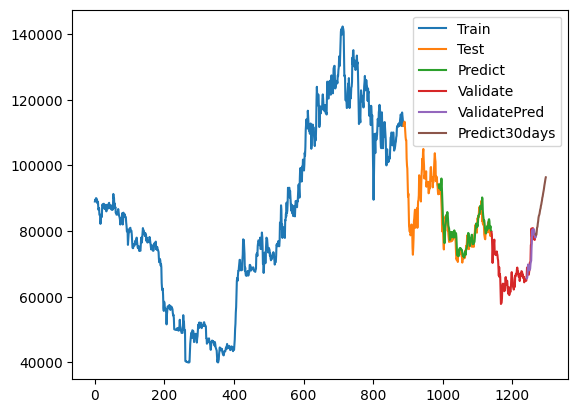

In [52]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

<h1># 4. Split the data into training, testing, and validation arcording to 5:3:2

In [53]:
train_size = int(0.5 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [54]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [55]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [56]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [57]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [58]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
9/9 [==============================] - 2s 83ms/step - loss: 0.1126 - val_loss: 0.0057
Epoch 2/100
9/9 [==============================] - 0s 50ms/step - loss: 0.0121 - val_loss: 0.0214
Epoch 3/100
9/9 [==============================] - 0s 23ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 4/100
9/9 [==============================] - 0s 22ms/step - loss: 0.0023 - val_loss: 0.0047
Epoch 5/100
9/9 [==============================] - 0s 22ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 6/100
9/9 [==============================] - 0s 24ms/step - loss: 0.0011 - val_loss: 0.0039
Epoch 7/100
9/9 [==============================] - 0s 22ms/step - loss: 9.5712e-04 - val_loss: 0.0024
Epoch 8/100
9/9 [==============================] - 0s 23ms/step - loss: 8.2029e-04 - val_loss: 0.0026
Epoch 9/100
9/9 [==============================] - 0s 23ms/step - loss: 7.6182e-04 - val_loss: 0.0022
Epoch 10/100
9/9 [==============================] - 0s 23ms/step - loss: 7.0359e-04 - val_loss: 0.0020
Epo

In [59]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

5/5 [==============================] - 0s 6ms/step


In [60]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val, yval, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [61]:
from sklearn.metrics import mean_absolute_error
# 12. Đánh giá độ chính xác thuật toán bằng RMSE , MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))


mae_test = mean_absolute_error(ytest, y_pred)
mae_val = mean_absolute_error(yval, y_pred_val)

mape_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
mape_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print("Validate MAE: ", mae_val)
print("Test MAE: ", mae_test)
print("Validate MAPE: ", mape_val)
print("Test MAPE: ", mape_test)

Validation RMSE: 1837.1310322965057
Testing RMSE: 3098.6976153173614
Validate MAE:  1370.0705933415036
Test MAE:  2365.7502240143367
Validate MAPE:  1.97518473626591
Test MAPE:  2.3307910719362455


In [62]:
# 13. Dự báo 30 ngày tiếp theo

x_input=val_data[154:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]

n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.37649733]
101
1 day input [0.17795657 0.19066566 0.22194957 0.23368104 0.23465866 0.21510622
 0.23270342 0.2229272  0.21217335 0.21510622 0.22097195 0.25225586
 0.25421111 0.23563629 0.23074817 0.2405244  0.24345726 0.22781531
 0.21315097 0.20435237 0.20826286 0.22390482 0.20044189 0.21021811
 0.21706146 0.20924049 0.21608384 0.22977055 0.25616635 0.26887544
 0.25616635 0.25225586 0.24443489 0.22488244 0.22390482 0.21706146
 0.23368104 0.2317258  0.22488244 0.2581216  0.25616635 0.26398733
 0.26398733 0.26398733 0.27767404 0.28256215 0.27474117 0.27278593
 0.26007684 0.25518873 0.25616635 0.25518873 0.24247964 0.25030062
 0.26496495 0.25714397 0.2581216  0.27180831 0.27083069 0.26887544
 0.25616635 0.26203209 0.25225586 0.25030062 0.25518873 0.23856915
 0.24541251 0.24834537 0.24345726 0.24247964 0.24345726 0.24345726
 0.25616635 0.28256215 0.28158453 0.27376355 0.27474117 0.26203209
 0.26105446 0.26985306 0.27669642 0.29722649 0.29820411 0.30113697
 0.34904046 0.35295095 0.3988992 

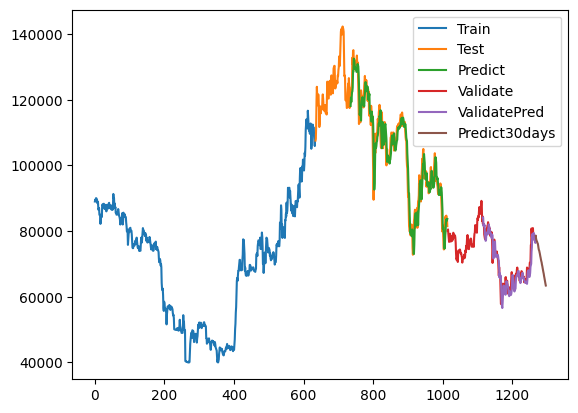

In [63]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()


<h1># 4. Split the data into training, testing, and validation arcording to 6:3:1

In [66]:
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [67]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [68]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [69]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [70]:
# 8. Define LSTM Model

model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [71]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
11/11 [==============================] - 1s 43ms/step - loss: 0.0190 - val_loss: 0.0032
Epoch 2/100
11/11 [==============================] - 0s 21ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 3/100
11/11 [==============================] - 0s 21ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 4/100
11/11 [==============================] - 0s 20ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 5/100
11/11 [==============================] - 0s 22ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 6/100
11/11 [==============================] - 0s 21ms/step - loss: 0.0011 - val_loss: 9.8313e-04
Epoch 7/100
11/11 [==============================] - 0s 21ms/step - loss: 9.7857e-04 - val_loss: 9.3627e-04
Epoch 8/100
11/11 [==============================] - 0s 20ms/step - loss: 8.3034e-04 - val_loss: 9.1882e-04
Epoch 9/100
11/11 [==============================] - 0s 21ms/step - loss: 7.4334e-04 - val_loss: 8.6521e-04
Epoch 10/100
11/11 [==============================] - 0s 22ms/step - los

In [72]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 28ms/step


In [73]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val, yval, ytest
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [74]:
from sklearn.metrics import mean_absolute_error
# 12. Đánh giá độ chính xác thuật toán bằng RMSE , MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))


mae_test = mean_absolute_error(ytest, y_pred)
mae_val = mean_absolute_error(yval, y_pred_val)

mape_test = np.mean(np.abs((ytest - y_pred) / ytest)) * 100
mape_val = np.mean(np.abs((yval - y_pred_val) / yval)) * 100

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)
print("Validate MAE: ", mae_val)
print("Test MAE: ", mae_test)
print("Validate MAPE: ", mape_val)
print("Test MAPE: ", mape_test)

Validation RMSE: 1817.7954113787139
Testing RMSE: 2233.5534859713234
Validate MAE:  1453.4359085648148
Test MAE:  1677.2485159050177
Validate MAPE:  1.9596229671671146
Test MAPE:  1.9211168014421736


In [77]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[28:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1



[0.37845132]
101
1 day input [0.17795657 0.19066566 0.22194957 0.23368104 0.23465866 0.21510622
 0.23270342 0.2229272  0.21217335 0.21510622 0.22097195 0.25225586
 0.25421111 0.23563629 0.23074817 0.2405244  0.24345726 0.22781531
 0.21315097 0.20435237 0.20826286 0.22390482 0.20044189 0.21021811
 0.21706146 0.20924049 0.21608384 0.22977055 0.25616635 0.26887544
 0.25616635 0.25225586 0.24443489 0.22488244 0.22390482 0.21706146
 0.23368104 0.2317258  0.22488244 0.2581216  0.25616635 0.26398733
 0.26398733 0.26398733 0.27767404 0.28256215 0.27474117 0.27278593
 0.26007684 0.25518873 0.25616635 0.25518873 0.24247964 0.25030062
 0.26496495 0.25714397 0.2581216  0.27180831 0.27083069 0.26887544
 0.25616635 0.26203209 0.25225586 0.25030062 0.25518873 0.23856915
 0.24541251 0.24834537 0.24345726 0.24247964 0.24345726 0.24345726
 0.25616635 0.28256215 0.28158453 0.27376355 0.27474117 0.26203209
 0.26105446 0.26985306 0.27669642 0.29722649 0.29820411 0.30113697
 0.34904046 0.35295095 0.3988992 

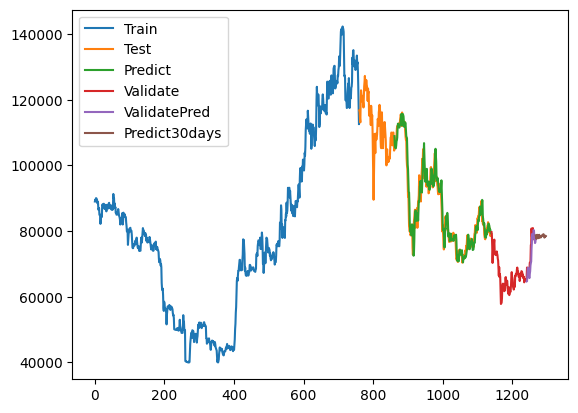

In [78]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()